In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stat

**Photons from photomultipliers**

Here we will calculate metrics for observing a signal commensurate with 8 photons from a photomultiplier tube in which we expect to see an average of 6 over a time period of 100 picoseconds.  This will be modeled using a Poisson PDF.

One experiment is defined as the integral in 100 picoseconds, which we will model by drawing from a Poisson distribution with a mean of 6.  The result is binomial in the sense that we either get 8 or we get another observation.

In the first step, we will calculate what the true mean value should be.  This is driven by the Poisson probability to get 8 given a mean of 6.  


In [2]:
# First step!

# Calculate true probability to get 8 photons
trueMean = np.exp(-6)*np.power(6,8)/np.math.factorial(8)
print("True Poisson mean of P(8|6)=",trueMean)

# The variance for Binomial is N*p*(1-p), but you will see that I'm going to calculate the
# sample variance from an array of 0's and 1's.  Thus, the variance will be 1*p(1-p) due to
# this trick.  I'm effectively dividing out N by doing this.
trueVar = trueMean*(1-trueMean)
print("True binomial variance for p=",trueMean," is ",trueVar)

print("\n\nFor a trial of 1000 experiments, we expect Np=1000*p=",round(trueMean*1000,2)," successes on average.")
print("For a trial of 1000 experiments, we expect a variance of Np(1-p)=",round(trueVar*1000,2))

True Poisson mean of P(8|6)= 0.1032577335308443
True binomial variance for p= 0.1032577335308443  is  0.09259557399691745


For a trial of 1000 experiments, we expect Np=1000*p= 103.26  successes on average.
For a trial of 1000 experiments, we expect a variance of Np(1-p)= 92.6


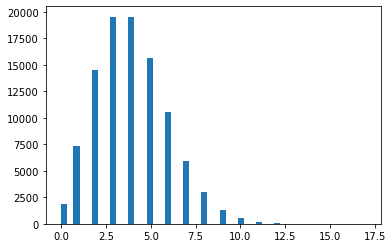

In [3]:
# Make a histogram of the Poisson distribution!
# Remind ourselves that Poisson is discrete

poissonData = np.random.poisson(4,100000)

n,bins,patches = plt.hist(poissonData,50,density=False)

plt.show()


**Second Step**

In the second step, we will find the average number of observations of 8 photons over a range of experiments: 10->1E7.  At the same time, we will calculate the variance over the range of experiments.  This will be done in two different ways.

*_First way_*:  If we treat the successes (finding 8) as binomial, then we can allow failures to comprise the second possibility.  If we assign success as 1 and failure as 0, then the probability for success is just the average of all outcomes.  Likewise, the variance of this distribution is the variance for success outcomes.  However, these calculations will yield p (probability for success) and p(1-p) (variance divided by the number of trials N).  IE, they will be values in [0,1] and not the Np and Np(1-p) values for the mean and variance of the binomial.  So this is a bit of a trick that makes the job a bit easier.

*_Second way_*: If we want to calculate the variance in the standard manner of calculating the mean number of successes and the mean square number of successes, we have to repeat each trial that yields an estimate of the mean. If a trial of N experiments will on average yield Np successes, the distribution of successes will have a variance of Np.

In [4]:
#Here is the first way, using a trick to speed things up

# Calculate mean value for a range of trials from 10 to 1E7
def oneExperiment(mean,value):
    #calculate a random poisson trial for a given mean value
    result = np.random.poisson(mean)

    #the result is either equal to our target...or it's not
    if result == value: 
        return 1.0
    return 0.0 

means = []
varis = []
for E in range(1,8):
    N = np.power(10,E)
    expData = []
    print("Processing data for N=",N)

    for i in range(1,N+1):
        exp = oneExperiment(6,8)
        expData.append(exp)
    means.append(np.mean(expData))
    varis.append(np.var(expData)) # I am cheating by using the numpy variance function!


Processing data for N= 10
Processing data for N= 100
Processing data for N= 1000
Processing data for N= 10000
Processing data for N= 100000
Processing data for N= 1000000
Processing data for N= 10000000


In [5]:
# Report your data...note that this is in a separate cell, so we don't 
# have to recalculate evrey time!

print("The mean number of 8 photon events\n",means,"\n\n")
print("The variance of 8 photon events\n",varis,"\n\n")

# Note that these are the mean and variance of a BINOMIAL distribution 
# with a mean given by the Poisson (with mean 6) probability to yield 8

The mean number of 8 photon events
 [0.2, 0.11, 0.095, 0.0959, 0.10533, 0.103491, 0.1032531] 


The variance of 8 photon events
 [0.16000000000000006, 0.09790000000000001, 0.085975, 0.08670318999999997, 0.0942355911, 0.09278061291899999, 0.09259189734039001] 




Text(0, 0.5, 'Mean N=8')

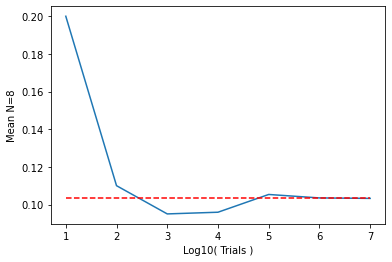

In [6]:
# Plot the mean values along with the true value!

xvals = 1+np.arange(0,7,1)
plt.plot(xvals,means)
plt.plot(xvals,trueMean+xvals*0,'r--')
plt.xlabel("Log10( Trials )")
plt.ylabel("Mean N=8")

Text(0, 0.5, 'Variance N=8')

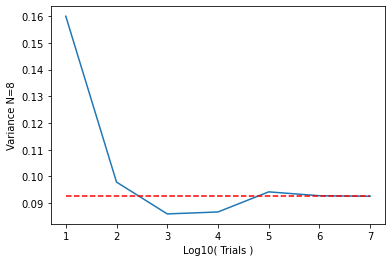

In [7]:
# Plot the variance values along with the true value!

plt.plot(xvals,varis)
plt.plot(xvals,trueVar+xvals*0,'r--')
plt.xlabel("Log10( Trials )")
plt.ylabel("Variance N=8")

In [8]:
# Here is the second way, doing things "correctly" but with a more costly calculation

## What if I didn't cheat by using the numpy variance function?
## How would I work out the sample variance "by hand"?

# Let's fix the number of trials at 1E3, as that was close to convergence
# And then we will simply run that number of trials a variable number of times.
#
# We can thus compare the average mean and variance calculated from 1E3 trials 
# repeated 10, 100, 100,... times in succession.

sums = []
varis = []
for t in range(1,6): # exponent for repeated trials
    T = np.power(10,t) # this is the number of times we will run 1E3 trials
    print("Processing data for T=",T)

    sumData = 0
    sum2Data = 0
    for r in range(1,T+1):   
        aSum = 0
        for E in range(1,1001): # We are now always running 1E3 trials
            exp = oneExperiment(6,8)
            aSum = aSum + exp
        sumData = sumData + aSum # use this to find average total successes in 1E3 trials
        sum2Data = sum2Data + aSum*aSum # use this to find average total successes squared
    
    sumData = sumData / T  # calculate mean
    sum2Data = sum2Data / T # calculate average N^2
    print(sumData,sum2Data)

    sums.append(sumData) # mean number of successes over T repeats of the trial runs
    varis.append(sum2Data-sumData*sumData) # variance in number of successes

print(sums)
print(varis)

Processing data for T= 10
102.1 10552.1
Processing data for T= 100
102.74 10656.18
Processing data for T= 1000
103.002 10707.34
Processing data for T= 10000
103.3982 10786.519
Processing data for T= 100000
103.19044 10740.38928
[102.1, 102.74, 103.002, 103.3982, 103.19044]
[127.69000000000233, 100.67240000000129, 97.92799600000035, 95.33123675999923, 92.12237260639995]


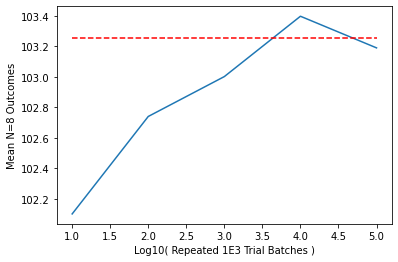

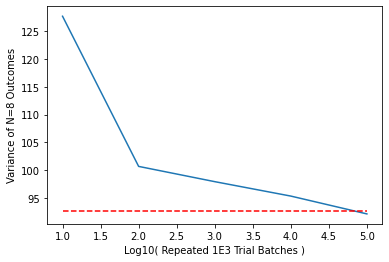

In [9]:
# Plot the mean values along with the true value!
xvals = 1+np.arange(0,5,1)

plt.plot(xvals,sums)
plt.plot(xvals,1000*trueMean+xvals*0,'r--')
plt.xlabel("Log10( Repeated 1E3 Trial Batches )")
plt.ylabel("Mean N=8 Outcomes")
plt.show()

# Plot the variance values along with the true value!
plt.plot(xvals,varis)
plt.plot(xvals,1000*trueVar+xvals*0,'r--')
plt.xlabel("Log10( Repeated 1E3 Trial Batches )")
plt.ylabel("Variance of N=8 Outcomes")
plt.show()